# Project 3: Web APIs and NLP <br>

#### Brandie Hatch

### Modeling

## Imports, Data Reading, and Model Prep

In [10]:
# python library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, Ridge, Lasso, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.svm import LinearSVC, SVC 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


%matplotlib inline
pd.options.display.max_columns =999

import requests
import time
import re
import nltk

In [11]:
# Read in Data

df = pd.read_csv('./data/prepped.csv', index_col=False)
print(df.shape)
df.head()

(9150, 11)


,subreddit,title,selftext,ups,score,num_comments,subreddit_num,title_length,title_word_count,selftext_length,selftext_word_count
0,Dogtraining,Trick of the Month - May 2022 - Crawl Backwards,Welcome to the Trick of the Month!\n\nThis mon...,8,8,4,1,47,10,856,140
1,Dogtraining,How do I get a cafe/brewery dog?,I am sitting at a brewery right now and all th...,311,311,88,1,32,7,337,67
2,Dogtraining,Warning: Gross,I noticed my dog trying to eat the poop of oth...,19,19,40,1,14,2,249,49
3,Dogtraining,My 3 months samoyed forgot all his training af...,"As the title says, after having stomach issues...",28,28,18,1,71,14,680,138
4,Dogtraining,Two mat questions!,Hi! I have a dog bed in the living room and I’...,6,6,0,1,18,3,797,157


In [12]:
df['text'] = df['title'] + " " + df['selftext']

In [13]:
X = df['text']
y = df['subreddit_num']

In [14]:
y.value_counts(normalize=True)

1    0.502732
0    0.497268
Name: subreddit_num, dtype: float64

In [15]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [16]:
# Instantiate and fit the transformer.
tvec = TfidfVectorizer()

c:\Users\hatch\anaconda3\envs\dsi-222\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


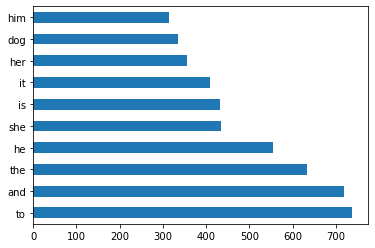

In [17]:
# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [18]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [19]:
pipe_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [20]:
# Instantiate GridSearchCV.

gs_tvec = GridSearchCV(pipe_tvec, # what object are we optimizing?
                        param_grid = pipe_tvec_params, # what parameters values are we searching?
                        cv=5) # 5-fold cross-validation.

In [21]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [22]:
gs_tvec.best_params_

{'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None}

In [23]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

1.0

In [24]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

1.0

In [25]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 1.0


c:\Users\hatch\anaconda3\envs\dsi-222\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


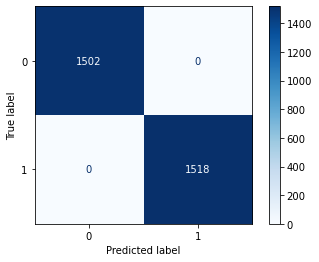

In [26]:
# visualize this

plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d');

In [28]:
# Create DataFrame with column for predicted values.
results = pd.DataFrame(gs_tvec.predict(X_test), columns=['predicted'])
# Create column for observed values.
results['actual'] = y_test
results.head()

,predicted,actual
0,1,NaN
1,1,NaN
2,1,NaN
3,1,NaN
4,1,NaN


### Support Vector Machines (SVM): Linear SVC & C-Support Vector Classification

In [20]:
# define linspace variable
pgrid = {
    'C': 0.21060526315789474
}

In [34]:
# instantiate and fit gridsearch
gs_svm = GridSearchCV(LinearSVC(max_iter=100000), pgrid)

gs_svm.fit(X, y)

import warnings
warnings.simplefilter("ignore")

c:\Users\hatch\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\hatch\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\hatch\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\hatch\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [145]:
print(gs_svm.best_score_)
print(gs_svm.best_params_)

0.7707103825136612
{'C': 0.21060526315789474}


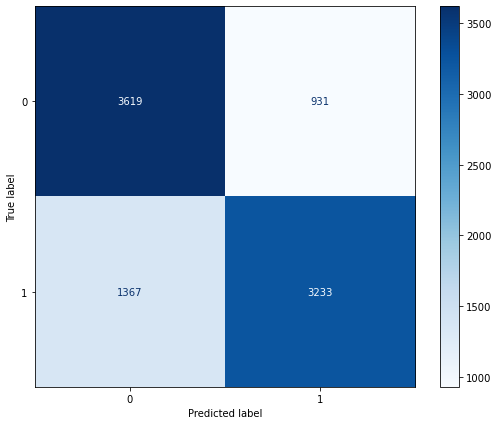

In [146]:
fig, ax = plt.subplots(figsize=(9, 7))
ConfusionMatrixDisplay.from_estimator(gs_svm, X, y, cmap='Blues', ax=ax);

In [147]:
(3619+1)/(3619+1+1367+3)

0.7254509018036072

In [27]:
y_test

6233    0
609     1
9019    0
3354    1
4256    1
       ..
4001    1
1354    1
1461    1
5088    0
6651    0
Name: subreddit_num, Length: 2745, dtype: int64

In [24]:
svc = SVC()
pgrid = {
    'C': np.logspace(-3, 10, 5),
    'kernel': ['poly'],
    'degree': [2],
    'gamma': np.logspace(-1, 3, 3) 
}
gs_svc = GridSearchCV(svc, pgrid)
# Fit on training data.
gs_svc.fit(X_train, y_train)
# Evaluate model.
gs_svc.score(X_test, y_test)

1.0

In [25]:
gs_svc.best_params_

{'C': 0.001, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}

In [28]:
# Create DataFrame with column for predicted values.
results = pd.DataFrame(gs_svc.predict(X_test), columns=['predicted'])
# Create column for observed values.
results['actual'] = y_test
results.head()

,predicted,actual
0,0,NaN
1,1,NaN
2,0,NaN
3,1,NaN
4,1,NaN


## Model Evaluation & Comparison

## Answer Problem, Conclusions, and Recommendations

## Sources